# 0. Carregando bibliotecas

In [ ]:
# Geospatial data processing
import numpy as np
import pandas as pd
import json
import geopandas as gpd
import networkx as nx
from shapely import Point


# Mapping and visualization
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D


# Network analysis
#import osmnx as ox

# The star of the show: city2graph for transportation network analysis
import city2graph

# Configure matplotlib for publication-quality visualizations
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.style.use('ggplot')
#plt.style.use('default')  # Clean default style instead of ggplot

print("All dependencies loaded successfully!")
print(f"city2graph version: {city2graph.__version__ if hasattr(city2graph, '__version__') else 'development'}")

All dependencies loaded successfully!
city2graph version: 0.1.6


# 1. Baixar dados Overture Maps

O código abaixo, faz o download dos dados, por tipo, mais recentes a partir de BBOX (longMax,latMax,longMin,atMin) ou de um Polígono.

In [57]:
# Carregar arquivos de referência da pesquisa
bbox_ae = [-42.865397,-5.231538,-42.662587,-4.955767] # Teresina city centre bounding box
area_estudo = gpd.read_file("dados/zona_urbana/area_estudo_zu.geojson").to_crs(epsg=31983)
bbox_ae_3km = [-42.863200,-5.259269, -42.626205, -4.929381]
area_estudo_buffer3km = gpd.read_file("dados/zona_urbana/area_estudo_zu_buffer3km_1.geojson").to_crs(epsg=31983)

area_estudo["area_m2"] = area_estudo.area
area_estudo.insert(loc=len(area_estudo.columns) - 1, column="area_km2", value=area_estudo.area / 1000000)

area_estudo_buffer3km["area_m2"] = area_estudo_buffer3km.area
area_estudo_buffer3km["area_km2"] = area_estudo_buffer3km.area/1000000

print(f"ÁREA DE ESTUDO (Km²) = {area_estudo["area_km2"]}")
print(f"ÁREA DE ESTUDO BUFFER 3KM (Km²) = {area_estudo_buffer3km["area_km2"]}")

ÁREA DE ESTUDO (Km²) = 0    279.000697
Name: area_km2, dtype: float64
ÁREA DE ESTUDO BUFFER 3KM (Km²) = 0    537.453272
Name: area_km2, dtype: float64


#### Caso já tenha feito o download dos dados, pule a célula abaixo

In [58]:
# Download data from Overture Maps (uncomment to download fresh data)
# This downloads building footprints, road segments, and connectors for Teresina city centre

city2graph.load_overture_data(
    area=bbox_ae_3km,
    types=["segment", "building", "connector"],
    output_dir="dados/overturemaps/intermediarios/",
    prefix="teresina_AE3km_script_",
    save_to_file=True,
    return_data=False
)

print("Dados baixados foi concluído.")

Dados baixados foi concluído.


#### Caso tenha pulado a célula acima, faça o carregamento dos dados armazenados localmente.

In [59]:
# Load the downloaded GeoJSON files
# Convert to UTM 23 Sul Grade (EPSG:31983) for accurate distance calculations
buildings_gdf_bboxae3km = gpd.read_file("./dados/overturemaps/intermediarios/teresina_AE3km_script_building.geojson").to_crs(epsg=31983)
segments_gdf_bboxae3km = gpd.read_file("./dados/overturemaps/intermediarios/teresina_AE3km_script_segment.geojson").to_crs(epsg=31983)
connectors_gdf_bboxae3km = gpd.read_file("./dados/overturemaps/intermediarios/teresina_AE3km_script_connector.geojson").to_crs(epsg=31983)
ubs_gdf_ae = gpd.read_file("./dados/semplam/ubs_zu.geojson").to_crs(epsg=31983)

print("✅ Dados Carregados com Sucesso!")
print("📊 Resumo do Conjunto de Dados:")

print(f"   • UBS: {len(ubs_gdf_ae):,}")
print(f"   • Buildings: {len(buildings_gdf_bboxae3km):,}")
print(f"   • Road segments: {len(segments_gdf_bboxae3km):,}")
print(f"   • Connectors: {len(connectors_gdf_bboxae3km):,}")
print("\n")
print("----------- SRC ORIGNAL -----------------")

print(f"   • Área de Estudo (ZU) -> CRS ORIGINAL: {area_estudo.crs}")
print(f"   • Área de Estudo (ZU Buffer 3 km) -> CRS ORIGINAL: {area_estudo_buffer3km.crs}")
print(f"   • UBS -> CRS ORIGINAL: {ubs_gdf_ae.crs}")
print(f"   • BUILDING -> CRS ORIGINAL: {buildings_gdf_bboxae3km.crs}")
print(f"   • SEGMENTS -> CRS ORIGINAL: {segments_gdf_bboxae3km.crs}")
print(f"   • CONNECTORS -> CRS ORIGINAL: {connectors_gdf_bboxae3km.crs}")

✅ Dados Carregados com Sucesso!
📊 Resumo do Conjunto de Dados:
   • UBS: 75
   • Buildings: 445,720
   • Road segments: 55,387
   • Connectors: 40,204


----------- SRC ORIGNAL -----------------
   • Área de Estudo (ZU) -> CRS ORIGINAL: EPSG:31983
   • Área de Estudo (ZU Buffer 3 km) -> CRS ORIGINAL: EPSG:31983
   • UBS -> CRS ORIGINAL: EPSG:31983
   • BUILDING -> CRS ORIGINAL: EPSG:31983
   • SEGMENTS -> CRS ORIGINAL: EPSG:31983
   • CONNECTORS -> CRS ORIGINAL: EPSG:31983


#### Plotando dados iniciais

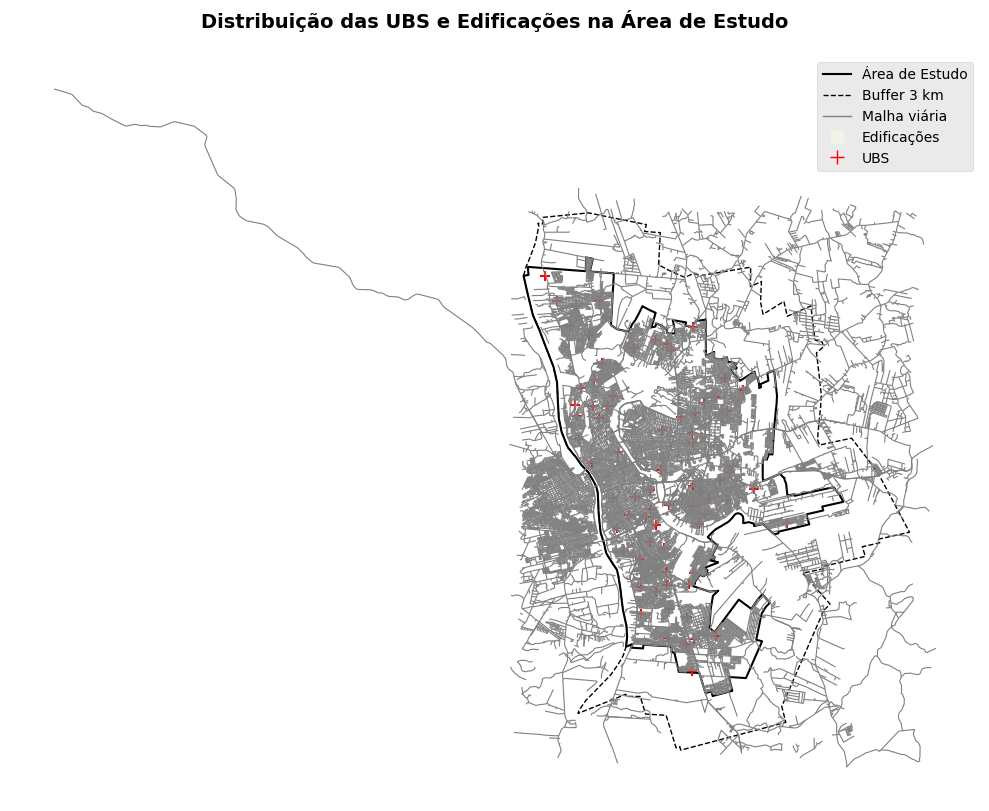

In [61]:
# --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 1️⃣ Buildings — bege claro, sem contorno
#buildings_gdf_bboxae3km.plot(ax=ax, facecolor='#f2f2e9', edgecolor='none', label='Edificações')

# 2️⃣ Malha viária — linhas cinza
segments_gdf_bboxae3km.plot(ax=ax, color='gray', linewidth=0.8, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 4️⃣ Área de Estudo — contorno preto contínuo
area_estudo.plot(ax=ax, facecolor='none', edgecolor='black', 
                 linewidth=1.5, label='Área de Estudo')

# 5️⃣ UBS — cruz vermelha
ubs_gdf_ae.plot(ax=ax, color='red', marker='+', markersize=50, label='UBS')

# --- Personalização do título e layout ---
ax.set_title("Distribuição das UBS e Edificações na Área de Estudo", 
             fontsize=14, fontweight='bold', pad=20)
ax.set_axis_off()

# --- Legenda personalizada ---
custom_legend = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='Área de Estudo'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='Buffer 3 km'),
    Line2D([0], [0], color='gray', linewidth=1, label='Malha viária'),
    Line2D([0], [0], marker='s', color='#f2f2e9', markeredgecolor='none',
           markersize=10, label='Edificações', linestyle=''),
    Line2D([0], [0], marker='+', color='red', markersize=10, label='UBS', linestyle='')
]

ax.legend(handles=custom_legend, loc='upper right', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

# 2. Operação Espacial (Intersecção)
Como parte da organização da base de dados, irei realizar a operação espacial INTERSEÇAO para obter apenas as "pegadas de construções", segmentos e conectores dentro da zona urbana 3km

## BUILDING

<Axes: >

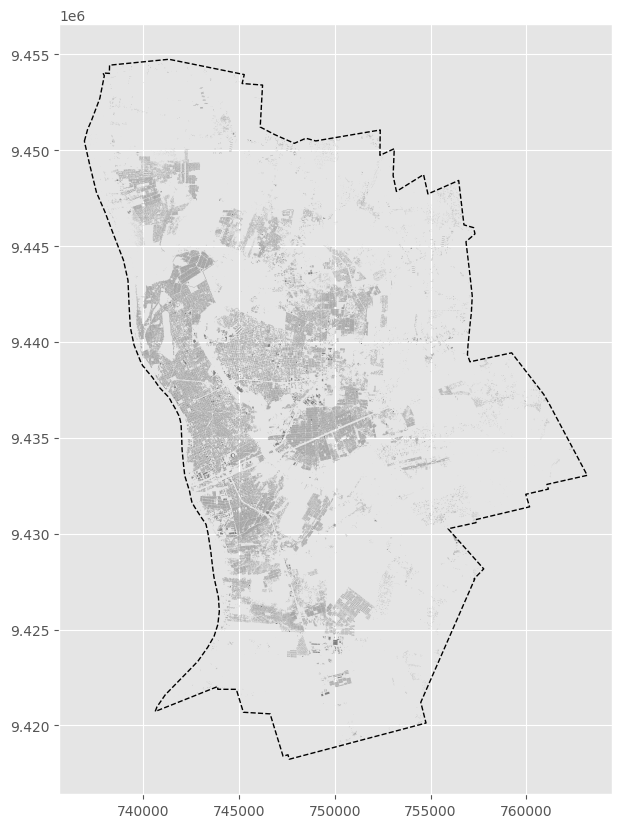

In [62]:
# Vamos realizar um operação espacial de interseção para obter apenas as vias dentro da zona urbana 3km
buildings_gdf_ae3km = buildings_gdf_bboxae3km.overlay(area_estudo_buffer3km, how='intersection')

# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
buildings_gdf_ae3km.plot(ax=ax, color='gray', linewidth=0.2, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

In [63]:
buildings_gdf_ae3km.to_file(
    "dados/overturemaps/buildings_ae3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
)

## SEGMENTOS

In [64]:
# Vamos realizar um operação espacial de interseção para obter apenas as vias dentro da zona urbana 3km
segments_gdf_ae3km = segments_gdf_bboxae3km.overlay(area_estudo_buffer3km, how='intersection')

In [67]:
# >>> INÍCIO DO NOVO CÓDIGO DE FILTRAGEM <<<
print(f"Número de segmentos de via antes da 1ª filtragem: {len(segments_gdf_ae3km)}")

# 1. PRIMEIRO FILTRO: Manter apenas subtype == 'road' (excluding pedestrian paths, railways, etc.)
segments_gdf_ae3km_road = segments_gdf_ae3km[segments_gdf_ae3km['subtype'] == 'road']
print(f"Número de segmentos após filtrar por subtype='road': {len(segments_gdf_ae3km_road)} ({len(segments_gdf_ae3km)-len(segments_gdf_ae3km_road)})")


# 2. SEGUNDO FILTRO: Sobre o resultado anterior, filtrar pela classe da via
vias_para_manter = [
    'primary', 
    'secondary', 
    'tertiary', 
    'trunk', 
    'residential', 
    'unclassified'
]
# Filtra o GeoDataFrame do passo 1, mantendo apenas as classes desejadas
segments_gdf_ae3km_road_class = segments_gdf_ae3km_road[segments_gdf_ae3km_road['class'].isin(vias_para_manter)]

print(f"Número de segmentos após filtrar por 'class' (resultado final): {len(segments_gdf_ae3km_road_class)} ({len(segments_gdf_ae3km_road)-len(segments_gdf_ae3km_road_class)})")

Número de segmentos de via antes da 1ª filtragem: 45224
Número de segmentos após filtrar por subtype='road': 45191 (33)
Número de segmentos após filtrar por 'class' (resultado final): 41246 (3945)


<Axes: >

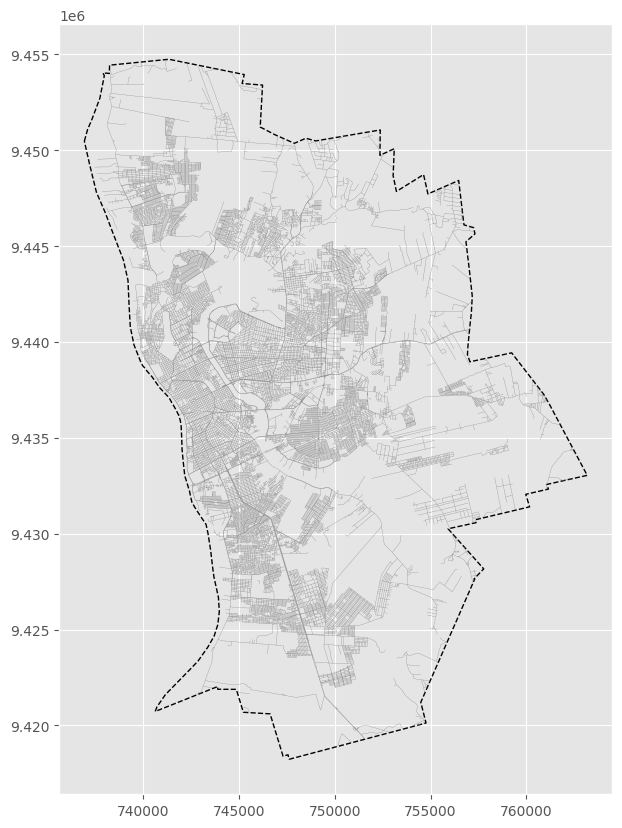

In [68]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
segments_gdf_ae3km_road_class.plot(ax=ax, color='gray', linewidth=0.2, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

In [70]:
segments_gdf_ae3km_road_class.to_file(
    "dados/overturemaps/segment_ae3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
)

## Conectores (Nós)

In [71]:
# Vamos realizar um operação espacial de interseção para obter apenas os conectores (nós) dentro da zona urbana 3km
connectors_gdf_ae3km = connectors_gdf_bboxae3km.overlay(area_estudo_buffer3km, how='intersection')

<Axes: >

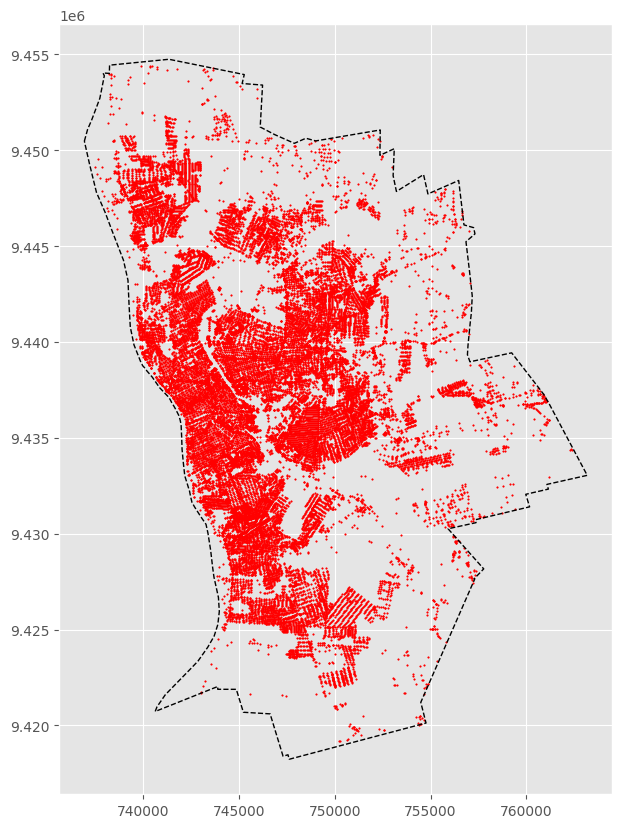

In [72]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
connectors_gdf_ae3km.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

## Sobrepondo os Nós ao Segmento

<Axes: >

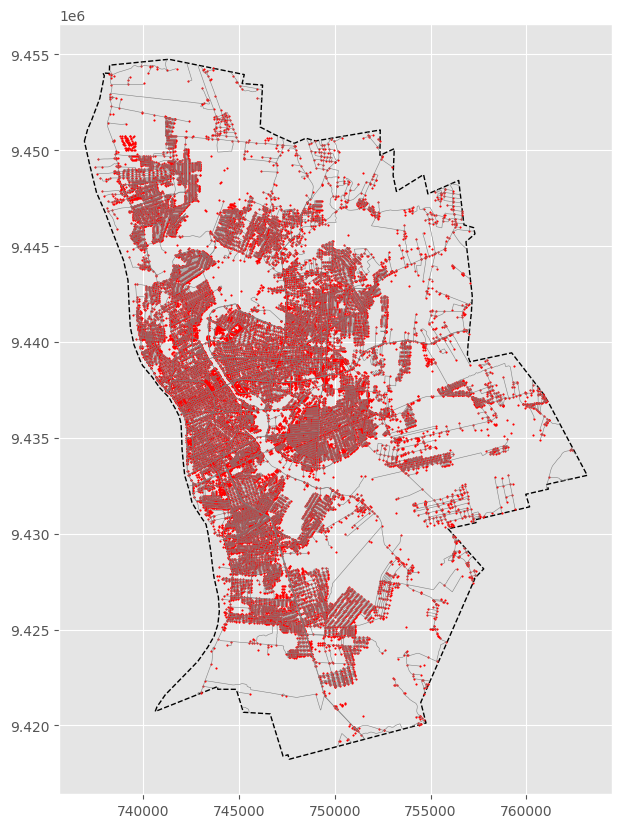

In [73]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
segments_gdf_ae3km_road_class.plot(ax=ax, color='gray', linewidth=0.4, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 5️⃣ Conectores de Trechos de rua — círculo vermelho
connectors_gdf_ae3km.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

Após a exclusão de alguns segmentos, alguns nó ficaram desconectados da rede. Necessário excluí-los.

In [84]:
# Vamos realizar um operação espacial de interseção para obter apenas os conectores (nós) que tocam a rede
print(f"Número total de nó antes da operação {len(connectors_gdf_ae3km)}")
connectors_gdf_ae3km_valid = connectors_gdf_ae3km.overlay(segments_gdf_ae3km_road_class, how='intersection')
# Encontrando pontos duplicados e removendo-os, deixando apenas o último valor
connectors_gdf_ae3km_valid_drop = connectors_gdf_ae3km_valid.drop_duplicates(['id_1'], keep='first')
print(f"Número total de nó depois da operação {len(connectors_gdf_ae3km_valid_drop)} ({len(connectors_gdf_ae3km) - len(connectors_gdf_ae3km_valid_drop)})")

Número total de nó antes da operação 33019
Número total de nó depois da operação 28777 (4242)


<Axes: >

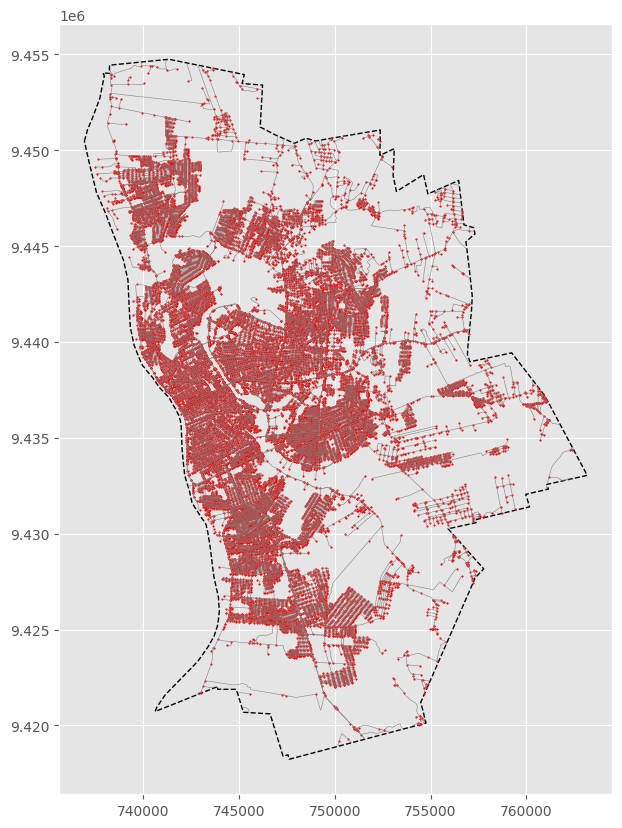

In [86]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
segments_gdf_ae3km_road_class.plot(ax=ax, color='gray', linewidth=0.4, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 5️⃣ Conectores de Trechos de rua — círculo vermelho
connectors_gdf_ae3km_valid_drop.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

In [87]:
connectors_gdf_ae3km_valid_drop.to_file(
    "dados/overturemaps/connectors_ae3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8'
)

# 3. Street Network Processing

Before creating morphological graphs, we need to process the raw street data. This involves:

1. **Filtering**: Keep only road segments (exclude pedestrian paths, railways, etc.)
2. **Barrier Processing**: Handle bridges and tunnels to create accurate spatial barriers
3. **Network Cleanup**: Ensure proper connectivity for graph operations

The `barrier_geometry` column will contain the processed geometries that act as spatial barriers for tessellation.

In [6]:
buildings_gdf = gpd.read_file("./dados/overturemaps/buildings_ae3km.geojson", columns=['id', 'subtype', 'class', 'geometry'])

segments_gdf = gpd.read_file("./dados/overturemaps/segment_ae3km.geojson", columns=['id', 'subtype', 'class', 'names', 'connectors',
       'routes', 'subclass_rules', 'access_restrictions', 'level_rules',
       'destinations', 'prohibited_transitions', 'road_surface',
       'road_flags', 'speed_limits', 'width_rules', 'subclass', 'geometry'])

connectors_gdf = gpd.read_file("./dados/overturemaps/connectors_ae3km.geojson", columns=["id_1","geometry"])

In [8]:
import pandas as pd
import json

# --- 1. Mapeamentos baseados no Código de Trânsito Brasileiro (CTB) ---

# Dicionário com as velocidades MÁXIMAS legais (em km/h)
speed_max_map_ctb = {
    'trunk': 80.0,        # Via de Trânsito Rápido
    'primary': 60.0,      # Via Arterial
    'secondary': 40.0,    # Via Coletora
    'tertiary': 40.0,     # Via Coletora
    'residential': 30.0,  # Via Local
    'unclassified': 30.0  # Via Local
}

# Dicionário com as velocidades MÍNIMAS legais (metade da máxima)
speed_min_map_ctb = {key: value / 2 for key, value in speed_max_map_ctb.items()}

# Dicionário com as velocidades MÉDIAS REALISTAS para modelagem
speed_avg_map_model = {
    'trunk': 50.0,
    'primary': 40.0,
    'secondary': 30.0,
    'tertiary': 25.0,
    'residential': 20.0,
    'unclassified': 20.0
}


# --- 2. Função para preencher os valores nulos em 'speed_limits' com dados do CTB ---
def preencher_limites_ctb(row):
    """
    Preenche 'speed_limits' nulos com os valores MÁXIMOS e MÍNIMOS do CTB.
    """
    if pd.isna(row['speed_limits']):
        road_class = row['class']
        
        # Pega os valores max e min dos nossos mapas CTB
        max_speed = speed_max_map_ctb.get(road_class, 30.0) # Default de 30 para segurança
        min_speed = speed_min_map_ctb.get(road_class, 15.0) # Default de 15
        
        data_structure = [{
            "min_speed": { "value": min_speed, "unit": "km\\/h" }, # Preenchendo min_speed
            "max_speed": { "value": max_speed, "unit": "km\\/h" },
            "is_max_speed_variable": None,
            "when": None,
            "between": None
        }]
        return json.dumps(data_structure)
    else:
        return row['speed_limits']

# --- 3. Aplicar a função para atualizar a coluna 'speed_limits' ---
print("Preenchendo 'speed_limits' com valores MÁX/MÍN do CTB...")
segments_gdf['speed_limits'] = segments_gdf.apply(preencher_limites_ctb, axis=1)
print("Coluna 'speed_limits' atualizada.")


# --- 4. Criar a nova coluna com a VELOCIDADE MÉDIA para modelagem ---
print("\nCriando coluna de velocidade média para modelagem...")
# A função .map() é uma forma muito eficiente de fazer isso
segments_gdf['velocidade_media_kmh'] = segments_gdf['class'].map(speed_avg_map_model)
# Preencher qualquer valor que não foi mapeado (caso haja uma 'class' inesperada)
segments_gdf['velocidade_media_kmh'].fillna(20.0, inplace=True)
print("Coluna 'velocidade_media_kmh' criada.")

Preenchendo 'speed_limits' com valores MÁX/MÍN do CTB...
Coluna 'speed_limits' atualizada.

Criando coluna de velocidade média para modelagem...
Coluna 'velocidade_media_kmh' criada.


<positron-console-cell-8>:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [ ]:
# --- 5. Calcular o TEMPO DE VIAGEM a partir da velocidade MÉDIA ---
print("\nCalculando o tempo de viagem a partir da velocidade média...")
# Converter a velocidade média para m/min
velocidade_mmin = segments_gdf['velocidade_media_kmh'] * 1000 / 60
# Calcular o tempo de viagem em min
segments_gdf['tempo_viagem_min'] = segments_gdf.geometry.length / velocidade_mmin
print("Coluna 'tempo_viagem_min' criada e pronta para a análise de isócronas.")


# --- 6. Verificação Final ---
print("\nVerificação Final:")
# Contar nulos na coluna principal (esperado: 0)
print(f"Nulos em 'speed_limits': {segments_gdf_zu['speed_limits'].isna().sum()}")
# Contar nulos na coluna de velocidade média (esperado: 0)
print(f"Nulos em 'velocidade_media_kmh': {segments_gdf_zu['velocidade_media_kmh'].isna().sum()}")

print("\nAmostra do resultado final com as novas colunas:")
display(segments_gdf_zu[['class', 'speed_limits', 'velocidade_media_kmh', 'tempo_viagem_min']].sample(5))

# 2.1 Processamento dos Nó sem grafo

Após a filtrangem dos segmentos do tipo road e das class, algum nós ficaram sem aresta e devem ser  excluídos do conjunto

In [ ]:
import geopandas as gpd

# --- Pré-requisito: Garantir que ambos os GeoDataFrames tenham o mesmo CRS ---
# Se eles não tiverem o mesmo CRS, a operação falhará.
if connectors_gdf.crs != segments_gdf.crs:
    print("Aviso: Os CRS são diferentes. Projetando os nós para o CRS dos segmentos...")
    connectors_gdf = connectors_gdf.to_crs(segments_gdf.crs)

# --- A Solução ---
print(f"Número de nós ANTES da limpeza: {len(connectors_gdf)}")

# Realiza a junção espacial. Mantém apenas os nós que intersectam a rede de segmentos.
# how='inner': Só mantém os nós que encontram uma rua correspondente.
# predicate='intersects': A regra para a correspondência espacial.
connectors_gdf_zu_ok = gpd.sjoin(connectors_gdf, segments_gdf, how="inner", predicate="intersects")

# --- Limpeza Final ---
# A junção espacial adiciona colunas do GeoDataFrame de segmentos.
# Vamos remover duplicatas caso um nó toque mais de uma rua e manter apenas as colunas originais dos nós.
# Primeiro, obtemos o nome das colunas originais dos nós.
colunas_originais_nos = connectors_gdf.columns

# Remove duplicatas de nós (baseado no índice original) e seleciona as colunas originais
connectors_gdf_zu_ok = connectors_gdf_zu_ok.drop_duplicates(subset='index_right').loc[:, colunas_originais_nos]


print(f"Número de nós APÓS a limpeza: {len(connectors_gdf_zu_ok)}")

# Agora, 'nos_conectados_gdf' contém apenas os pontos que estão conectados à sua rede filtrada.

## Check-Point dos dados: Salvar em arquivos físicos:

- segments_gdf_zu
- buildings_gdf_zu

In [ ]:
# Extra controle
# ===================================================================
# ===================================================================

# Exportar o GeoDataFrame para o formato GeoJSON
# É uma boa prática especificar a codificação para evitar problemas com caracteres especiais (acentos)
segments_gdf_zu.to_file(
    "dados/overturemaps/segments_zu3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

buildings_gdf_zu.to_file(
    "dados/overturemaps/intermediarios/buildings_zu3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

print("Arquivo GeoJSON salvo com sucesso")

In [ ]:
# Process segments to handle bridges/tunnels and create proper spatial barriers
segments_gdf_zu_barreiras = city2graph.process_overture_segments(
    segments_gdf=buildings_gdf_zu,
    get_barriers=True,
    connectors_gdf=connectors_gdf_zu,
    threshold=1.0
)

print(f"✅ Processed {len(segments_gdf_zu_barreiras)} road segments")
print("📈 Barrier geometries created for tessellation")

barriers = segments_gdf_zu_barreiras["barrier_geometry"]

# Check the geometry types in the barrier_geometry column
geometry_types = segments_gdf_zu_barreiras["barrier_geometry"].geom_type.value_counts()
print("\n🔍 Barrier geometry types:")
for geom_type, count in geometry_types.items():
    print(f"   • {geom_type}: {count:,}")

In [ ]:
barriers.plot()

In [ ]:
segments_gdf.head()

In [ ]:
# Extra controle
# ===================================================================
# ===================================================================

# Definir o nome do arquivo de saída
output_filename = 'dados/overturemaps/resultado/segments_road_filtrado.geojson'

# Exportar o GeoDataFrame para o formato GeoJSON
# É uma boa prática especificar a codificação para evitar problemas com caracteres especiais (acentos)
segments_gdf_filtrado1.to_file(
    output_filename, 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

print(f"Arquivo GeoJSON salvo com sucesso em: {output_filename}")

# 4. Creating Morphological Graphs

Now we’ll create the morphological graph - the core contribution of city2graph. This process:

![image.png](https://city2graph.net/_images/morph_net_process.png)

## The Process:

1. **Tessellation Creation**: Divide space into private areas using street segments as barriers
2. **Network Extraction**: Identify three types of spatial relationships:
    - Private-to-private (red): Adjacency between neighboring private spaces
    - Public-to-public (blue): Connectivity along street networks
    - Private-to-public (purple): Interface between private spaces and streets

## Why Morphological Graphs?

Unlike traditional approaches that analyze street networks and buildings separately, morphological graphs provide a **unified representation** of urban space that:

- Captures the complete topology of public and private spaces
- Enables holistic urban analysis combining street accessibility and land use
- Provides a foundation for spatially-explicit graph machine learning
- Supports integration of diverse urban attributes (POIs, demographics, functions)

In [ ]:
# Define center point for the analysis area (Centro da cidade de Teresina)
center_point = gpd.GeoSeries([Point(-5.08305465, -42.77597849)], crs='EPSG:4326').to_crs(epsg=31983)

# Garante que os índices sejam numéricos, simples e sequenciais
#buildings_gdf = buildings_gdf.reset_index(drop=True)
#segments_gdf = segments_gdf.reset_index(drop=True)

# Create the morphological graph
print("🏗️  Creating morphological graph...")
morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,                    # Analysis radius in meters
    clipping_buffer=300,            # Buffer for edge effects
    primary_barrier_col='barrier_geometry',
    contiguity="queen",             # Adjacency rule for tessellation
    keep_buildings=True,            # Preserve building geometries
)

print("✅ Morphological graph created successfully!")
print("📊 Network summary:")
print(f"   • Node types: {list(morpho_nodes.keys())}")
print(f"   • Edge types: {list(morpho_edges.keys())}")
print(f"   • Private spaces: {len(morpho_nodes['private']):,}")
print(f"   • Public spaces: {len(morpho_nodes['public']):,}")

for edge_type, edge_gdf in morpho_edges.items():
    print(f"   • {edge_type}: {len(edge_gdf):,} connections")

In [ ]:
morpho_nodes["private"].head()


In [ ]:
morpho_nodes["public"].head()


In [ ]:
morpho_edges[('public', 'connected_to', 'public')].head()


In [ ]:
morpho_edges[('private', 'faced_to', 'public')].head()


In [ ]:
morpho_edges[('private', 'touched_to', 'private')].head()


In [ ]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morpho_nodes["private"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morpho_nodes["private"]["building_geometry"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morpho_nodes["public"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morpho_edges[('private', 'touched_to', 'private')].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morpho_edges[('public', 'connected_to', 'public')].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morpho_edges[('private', 'faced_to', 'public')].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morpho_nodes["private"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morpho_nodes["public"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right',
frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()